### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [289]:
# Imports

import numpy as np
import imageio
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [290]:
# Global variables

IMAGE_DIR = '../images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax
params = ["x", "y", "r", "theta", "dr", "dgamma", "width", "colour"]

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


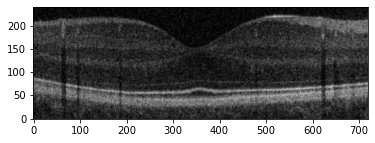

In [291]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(imageio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [292]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)

    def centre_point(self):
        return (self.x, self.y)


In [293]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [294]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [295]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

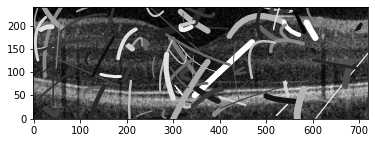

In [296]:
# Initialise clew of 100 and draw

clew = initialise_clew(100, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

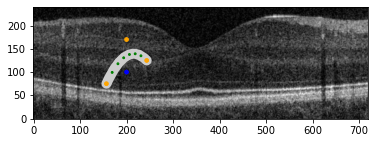

In [297]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')

drawing.show(save='bezier.png')

In [298]:
clew = initialise_clew(100, image.shape, (40, 30, 1))

In [299]:
def next_clew(best_clew, imshape, size=100):
    res = []
    for _ in range(size):
        # new_worm = random_worm(imshape, (40, 30, 1))
        new_params = {}
        # selects 2 parents for crossover
        parents = random.sample(best_clew, k=2)
        for param in params:
            
            good_worm = random.choice(parents)

            # Mutation
            if random.random() < 0.1:
                # TODO: Make mutation closer to good worm's attr (in most cases +/- 10%)
                new_param = good_worm.__getattribute__(param) * ((random.random() / 5) + 0.9)   # mutate between 90 - 110% of good worms attr value 
            else:
                new_param = good_worm.__getattribute__(param)
            # new_param = good_worm.__getattribute__(param)

            new_params[param] = new_param

        print(new_params)
        
        # clamp worm values so they dont become invalid for problem space
        new_worm = Camo_Worm(
            x= min(new_params["x"], imshape[1]),
            y= min(new_params["y"], imshape[0]), 
            r= new_params["r"], 
            theta= new_params["theta"], 
            deviation_r= new_params["dr"], 
            deviation_gamma= new_params["dgamma"], 
            width= new_params["width"],
            colour= min(new_params["colour"], 1.0)
            )
        res.append(new_worm)
    return res  
            

In [300]:
def costfn(clew: list[Camo_Worm], worm_idx: int, imshape: tuple, w_internal: float=1.0, w_dist: float=1.0):
    
    worm = clew[worm_idx]

    # Internal Score
    c_penalty = worm.dr
    desired_size = imshape[0] * imshape[1] / len(clew)
    internal_score = abs((desired_size - (2 * worm.r * worm.width))/desired_size) + c_penalty

    distance_score = 0
    
    
    for i in range(0, len(clew)):
        if i is not worm_idx:
            point1 = np.array(clew[i].centre_point())
            point2 = np.array(worm.centre_point())

            eu_distance = np.linalg.norm(point1 - point2)

            distance_score += 1 / eu_distance

    # print(f"Internal: {internal_score} - Distance: {distance_score * w_dist}")
    final_score = internal_score * w_internal + distance_score * w_dist
    return final_score


def get_cost(clew, imshape):
    return [costfn(clew, i, imshape) for i, worm in enumerate(clew)]

In [301]:
# # test

# for i, worm in enumerate(clew):
#     costfn(clew, i, w_dist=10)

In [302]:
def select_best_clew(clew, imshape):
    return [x for x,cost in sorted(zip(clew, get_cost(clew, imshape)), key=lambda x: x[1])[:int(len(clew)/8)]]

In [303]:
def train():
    clew = initialise_clew(100, image.shape, (40, 30, 1))

    drawing = Drawing(image)
    drawing.add_worms(clew)
    drawing.show()
    
    print(get_cost(clew, image.shape))
    for i in range(100):
        best_clew = select_best_clew(clew, image.shape)
        clew = next_clew(best_clew, image.shape, size=100)

    drawing = Drawing(image)
    drawing.add_worms(clew)
    drawing.show()
    
    return clew


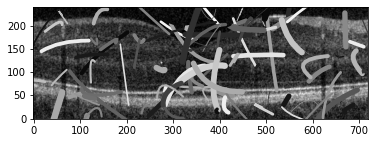

[12.77468478885, 23.979682225407586, 14.518984145219882, 2.928964346570684, 5.695540879519985, 16.106629585135977, 5.822660048266709, 62.022945180358576, 18.016839713757918, 4.906827854416946, 10.329273144259863, 78.80626071591512, 17.360589713163023, 59.2380623869171, 28.265653103893374, 3.054791539006344, 4.674455174679689, 13.3952413535191, 11.99911710597217, 44.84549498142617, 49.066274892417574, 31.63379016473516, 20.205604142219197, 28.47836942635042, 4.400599025885704, 8.216547913515884, 32.18092981899731, 27.03772331049937, 42.764780914974736, 16.25639987322615, 24.292385037475338, 11.66618543907951, 53.82881537146681, 20.80274638015572, 10.666348230061006, 4.764499758909038, 6.526901460909716, 33.79365239950986, 59.15063622845761, 7.931735399028882, 65.92207157737005, 11.794658929879905, 19.28323866220787, 20.891566227717735, 20.968193682690544, 42.684834617686995, 42.30653604649562, 21.68048469790601, 25.347767635701473, 24.177310839429353, 46.416539784325515, 2.1511825452495

/var/folders/70/ynf5hc3n58v8w5q1nxxwhg_c0000gn/T/ipykernel_59648/1461312047.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  distance_score += 1 / eu_distance


{'x': 443.6069079386905, 'y': 215.07896017125614, 'r': 66.06301483845624, 'theta': 1.7055788373889444, 'dr': 0.023671297392576764, 'dgamma': 0.7144400093839239, 'width': 2.0384425323928244, 'colour': 0.8777680564105506}
{'x': 653.2273025532793, 'y': 215.07896017125614, 'r': 17.129504692995795, 'theta': 0.37095668825515354, 'dr': 0.025136641738404065, 'dgamma': 0.22652618950986966, 'width': 5.0535230790635595, 'colour': 0.9196400931150811}
{'x': 523.0903896290661, 'y': 40.23931079333299, 'r': 60.934272376438905, 'theta': 1.8102583371955825, 'dr': 0.023671297392576764, 'dgamma': 2.8563355937529273, 'width': 1.9368583210895398, 'colour': 0.8777680564105506}
{'x': 486.0416173331299, 'y': 205.5268079144329, 'r': 66.06301483845624, 'theta': 1.381433221306557, 'dr': 0.6020253855749745, 'dgamma': 0.22652618950986966, 'width': 5.0535230790635595, 'colour': 0.9196400931150811}
{'x': 493.1499824747461, 'y': 215.07896017125614, 'r': 66.06301483845624, 'theta': 1.7126724338256198, 'dr': 0.023671297

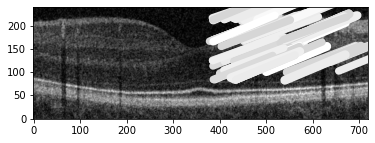

[inf,
 inf,
 inf,
 inf,
 2.063561698734622,
 1.930607185040001,
 inf,
 inf,
 inf,
 inf,
 1.3763205774178517,
 inf,
 inf,
 1.975267307044473,
 inf,
 inf,
 inf,
 2.177527515622507,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 1.8046993527250983,
 inf,
 inf,
 inf,
 inf,
 14.518741901084075,
 inf,
 1.9100931604779208,
 inf,
 5.545734753328955,
 inf,
 inf,
 inf,
 inf,
 inf,
 1.4410389676823947,
 inf,
 inf,
 1.0452268128754947,
 inf,
 inf,
 inf,
 inf,
 2.79894166987917,
 3.1361186504811256,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 2.0830358568632192,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 2.0768334687293653,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 1.6299207578133363,
 inf,
 inf,
 2.6954164637039013,
 inf,
 inf,
 inf,
 1.8542215511046332,
 inf,
 2.038990293541977,
 inf,
 inf,
 79.7379853395345,
 inf,
 inf,
 2.898326272941663,
 inf,
 inf,
 inf,
 inf]

In [304]:
# print(get_cost(train()))
get_cost(train(), image.shape)